In [1]:
import matplotlib
import scipy.io
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import pickle
from sklearn.linear_model import LinearRegression

In [32]:
def cost_matrix(weights, shape):
    Q = np.zeros((shape, shape))
    
    for i in range(shape):
        for j in range(shape):
            if i < shape // 2 and j < shape // 2:
                Q[i, j] = weights[i] if i == j else 0
            elif i >= shape // 2 and j >= shape // 2:
                Q[i, j] = weights[i - shape // 2] if i - shape // 2 == j - shape // 2 else 0
            elif i < shape // 2 and j >= shape // 2:
                Q[i, j] = -weights[j - shape // 2] if i == j - shape // 2 else 0
            elif i >= shape // 2 and j < shape // 2:
                Q[i, j] = -weights[i - shape // 2] if i - shape // 2 == j else 0
    
    return Q

In [31]:
def backwards_optimal_control(N, A, B, Q, Qk, R, shape):
    # amount of matrices = amount of time steps
    S = np.zeros((N,shape,shape))
    S[N-1,:,:] = Q
    L = np.zeros((N,1,shape))  # Changed L to a 2D array

    # backward pass
    for k in range(N-1,0, -1):
        # print("K = ", k)
        temp_1 = np.linalg.inv(R + B.T @ S[k,:,:] @ B)
        temp_2 = B.T @ S[k,:,:] @ A
        L[k - 1,:,:] = temp_1 @ temp_2
        S[k - 1,:,:] = Qk + (A.T @ S[k,:,:] @ A) - (A.T @ S[k,:,:] @ B) * L[k - 1,:,:]

    return L, S

In [33]:
def forward_optimal_control(N, A, B, R, L, x, shape):
    w = np.random.normal(0, R, (shape,1))
    for i in range(0, N - 1):
        x[i + 1,:,:] = (A - B @ L[i,:,:]) @ x[i,:,:] + w
    return x

In [2]:
# Known data
G = 0.14 # Nms
I = 0.15 # kgm^2
tau = 60 # ms
# geometry
l_forearm = 33 # cm - wrist-elbow
l_arm = 30 # cm - elbow-shoulder
# targets
r = 18 # cm
t = 0.6 # s - time reaching movement


In [3]:
# x[k+1] = A*x[k] + B*u[k]

# choose data for the state
theta = np.pi / 4# degrees (pi/4)
vel = r/t # cm/s
theta_dot = vel/l_forearm # rad/s
T = 0.5 # Ncm - random value
print("linear velocity : ", vel)
print("angular velocity : ", theta_dot)

# state vector x 
x = np.array((theta, theta_dot, T)).reshape(3,1)
print("state vector : ","\n", x)

# inputs u
u = 1
u = np.heaviside(u,1)
print("input : ", u)

linear velocity :  30.0
angular velocity :  0.9090909090909091
state vector :  
 [[0.78539816]
 [0.90909091]
 [0.5       ]]
input :  1.0


In [4]:
A = np.array([0,1,0,0,(-G/I),1/I,0,0,(-1/tau)]).reshape((3,3))
print("A matrix : ","\n",A)

A matrix :  
 [[ 0.          1.          0.        ]
 [ 0.         -0.93333333  6.66666667]
 [ 0.          0.         -0.01666667]]


In [5]:
B = np.array([0,0,(1/tau)]).reshape((3,1))
print("B matrix : ","\n", B)

B matrix :  
 [[0.        ]
 [0.        ]
 [0.01666667]]


In [6]:
# model implementation for single joint case and single reaching movement
# x[k+1] = A*x[k] + B*u[k]

y = np.matmul(A,x) + B*u
print("angular velocity : ", y[0], " corresponds to the initial computed value")
print("angular acceleration : ", y[1])
print("torque derivative : ", y[2])

angular velocity :  [0.90909091]  corresponds to the initial computed value
angular acceleration :  [2.48484848]
torque derivative :  [0.00833333]


targets  [(18.0, 0.0), (12.727922061357857, 12.727922061357857), (1.102182119232618e-15, 18.0), (-12.727922061357855, 12.727922061357857), (-18.0, 2.204364238465236e-15), (-12.727922061357859, -12.727922061357855), (-3.3065463576978533e-15, -18.0), (12.727922061357852, -12.727922061357859), (18.0, -4.408728476930472e-15)]


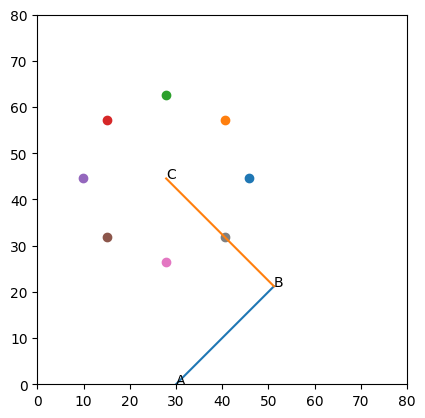

In [7]:
# plot starting position
theta_shoulder = 0
theta_elbow = 0
A = [30,0]
theta_shoulder = np.pi/4 # rad
theta_elbow = np.pi*3/4 #  rad
# compute joint positions 
B = [0,0]
B[0] = A[0] + np.cos(theta_shoulder)*l_arm
B[1] = A[1] + np.sin(theta_shoulder)*l_arm
C = [0,0]
C[0] = B[0] + np.cos(theta_elbow)*l_forearm
C[1] = B[1] + np.sin(theta_elbow)*l_forearm
#print(C)
#print('theta_shoulder (rad) ', theta_shoulder)
#print('theta_shoulder (deg) ', np.rad2deg(theta_shoulder))

# targets
points = [(np.cos(2*np.pi/8*x)*18,np.sin(2*np.pi/8*x)*18) for x in range(0,8+1)]
print('targets ', points)

# figure 
fig, ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')
centre = (C[0],C[1])
#ax.add_patch(Circle(centre,18,fill=False))
for i in range(0,8):
    plt.scatter(C[0]+points[i][0],C[1]+points[i][1])
plt.xlim(0,80)
plt.ylim(0,80)
plt.plot([A[0],B[0]],[A[1],B[1]])
plt.plot([B[0],C[0]],[B[1],C[1]])
labels = ['A','B','C']
plt.text(A[0],A[1],'A')
plt.text(B[0],B[1],'B')
plt.text(C[0],C[1],'C')

plt.show()

target:  [45.87867965644036, 44.5477272147525]
AC:  47.293048829948084
BC:  33.0


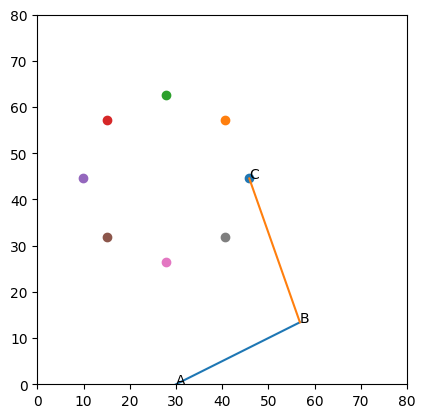

target:  [40.60660171779822, 57.27564927611036]
AC:  58.2494635168428
BC:  33.00000000000002


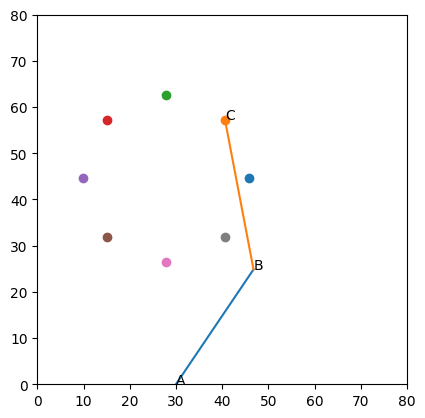

target:  [27.87867965644036, 62.5477272147525]
AC:  62.58368940651462
BC:  33.0


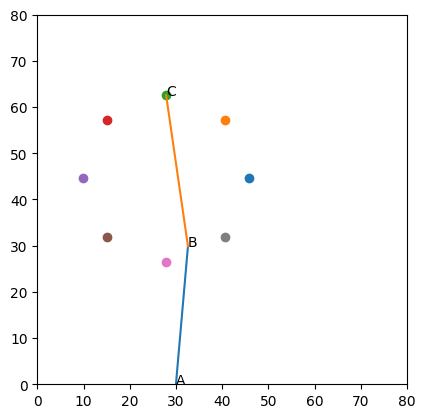

target:  [15.150757595082506, 57.27564927611036]
AC:  59.16924876994807
BC:  32.99999999999999


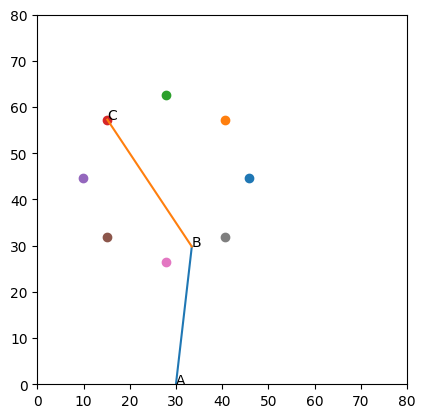

target:  [9.878679656440362, 44.5477272147525]
AC:  48.88115723229297
BC:  33.00000000000001


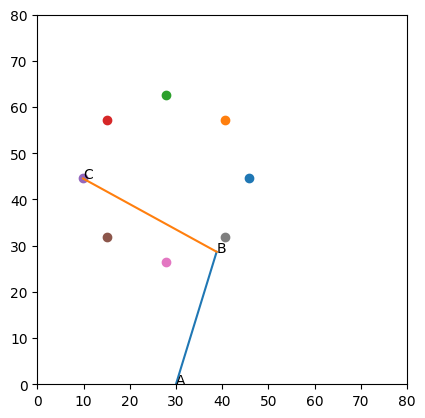

target:  [15.150757595082503, 31.819805153394643]
AC:  35.11409973215888
BC:  33.00000000000001


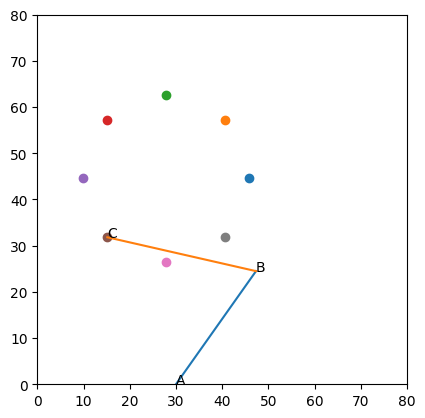

target:  [27.878679656440358, 26.5477272147525]
AC:  26.632345376795307
BC:  33.0


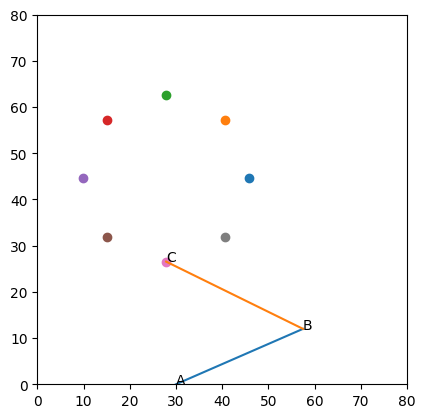

target:  [40.60660171779821, 31.81980515339464]
AC:  33.54101966249685
BC:  33.0


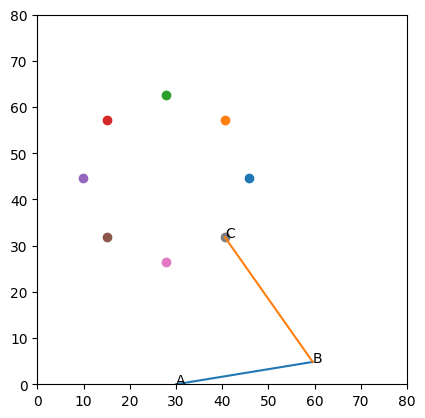

target:  [45.87867965644036, 44.54772721475249]
AC:  47.29304882994807
BC:  33.0


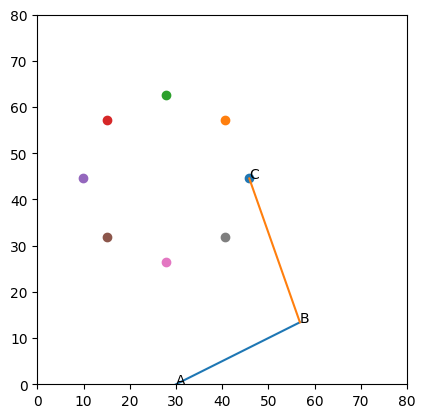

In [8]:
# change position over time
# constants
A = [30,0]

# figure
fig, ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')

for point in points :
    target = [C[0]+point[0], C[1]+point[1]]
    print('target: ',target)
    # distance A-target
    A_target = np.sqrt((target[0]-A[0])**2+(target[1]-A[1])**2)
    print('AC: ',A_target)
    
    # angle between AC and x-axis
    beta = np.arccos((A[0]-target[0])/A_target)
    # angle between AC and AB
    alpha = np.arccos((A_target**2+l_arm**2-l_forearm**2)/(2*A_target*l_arm))
    
    theta_shoulder = np.pi-beta-alpha

    # compute joint positions
    A = [30,0]
    B = [0,0]
    B[0] = A[0] + np.cos(theta_shoulder)*l_arm
    B[1] = A[1] + np.sin(theta_shoulder)*l_arm
    BC = np.sqrt((target[0]-B[0])**2+(target[1]-B[1])**2)
    print('BC: ',BC)
    
    # figure 
    plt.cla()
    plt.gca().set_aspect('equal', adjustable='box')
    centre = (C[0],C[1])
    #ax.add_patch(Circle(centre,18,fill=False))
    for i in range(0,8):
        plt.scatter(C[0]+points[i][0],C[1]+points[i][1])
    plt.xlim(0,80)
    plt.ylim(0,80)
    plt.plot([A[0],B[0]],[A[1],B[1]])
    plt.plot([B[0],target[0]],[B[1],target[1]])
    labels = ['A','B','C']
    plt.text(A[0],A[1],'A')
    plt.text(B[0],B[1],'B')
    plt.text(target[0],target[1],'C')
    
    plt.show()


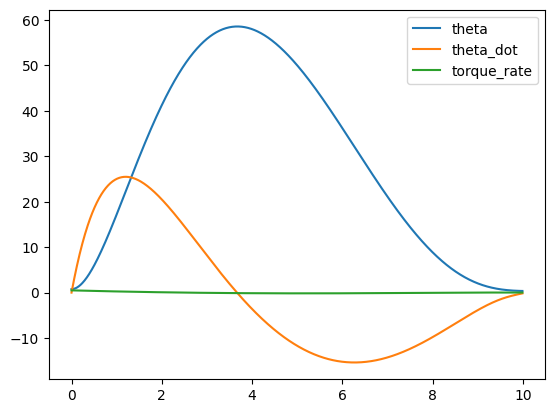

In [42]:
import time
import numpy as np

# One Joint Recursion Coding
theta = np.pi / 4
vel = r/t
theta_dot = 0
T = 0.5

dt = 0.01

Qk = np.zeros((6,6))
R = 0.0001
# weight matrix for one joint
weights = [5, 1, 2]
Q = cost_matrix(weights, 6)  
# Q = np.array([5,0,0,-5,0,0,0,1,0,0,-1,0,0,0,2,0,0,-2,-5,0,0,5,0,0,0,-1,0,0,1,0,0,0,-2,0,0,2]).reshape((6,6))

A = np.array([1,dt,0,0,0,0,0,1 - (dt * G/I),1 + dt/I,0,0,0,0,0,1 - dt/tau,0,0,0,
              0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1]).reshape((6,6))
B = np.array([0,0,(dt/tau),0,0,0]).reshape(6,1)

N = 1000

(L, S) = backwards_optimal_control(N, A, B, Q, Qk, R, 6)

x = np.zeros((N,6,1))
x[0,:,:] = np.array([theta,theta_dot, T, np.pi/8, 0, 0.5]).reshape((6,1))

x = forward_optimal_control(N, A, B, R, L, x, 6)   

x_axis = np.arange(0, 10, dt)
plt.plot(x_axis, x[:,0,0], label = "theta")
plt.plot(x_axis, x[:,1,0], label = "theta_dot")
plt.plot(x_axis, x[:,2,0], label = "torque_rate")
plt.legend()
plt.show()


A matrix :  
 [[1.         0.01       0.         0.         0.         0.        ]
 [0.         0.99066667 1.06666667 0.         0.         0.        ]
 [0.         0.         0.99983333 0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]]
B vector :  
 [[0.        ]
 [0.        ]
 [0.00016667]
 [0.        ]
 [0.        ]
 [0.        ]]
noise \ksi:  
 [[-1.20907486]
 [ 0.35569828]
 [-0.04344878]
 [ 0.13104139]
 [-0.89493587]
 [ 1.54665725]]
initial state estimation:  
 [[0.78539816]
 [0.        ]
 [0.5       ]
 [0.39269908]
 [0.        ]
 [0.5       ]]


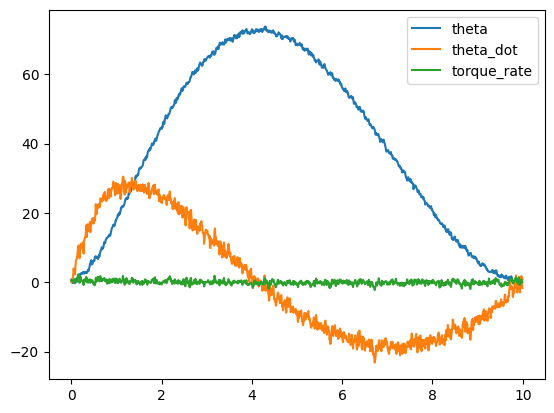

In [17]:
### definition of the state
# x[k+1] = A*x[k] + B*u[k] + ksi[k]
# y[k] = H*x[k] + w[k]

dt = 0.01
N = 1000
# matrices
A = np.array([1,dt,0,0,0,0,
              0,1-((dt*G)/I),1+dt/I,0,0,0,
              0,0,(1-dt/tau),0,0,0,
              0,0,0,1,0,0,
              0,0,0,0,1,0,
              0,0,0,0,0,1]).reshape((6,6))
print("A matrix : ","\n",A)
B = np.array([0,0,(dt/tau),0,0,0]).reshape(6,1)
print("B vector : ","\n",B)

# noise ksi[k] ~ N(0,Omega(ksi)), with Omega(ksi)=covariance matrix => 0=vector of means
means = np.zeros(6)
cov_ksi = np.zeros((6,6))
for i in range(0,6) :
    cov_ksi[i,i] = np.abs(np.random.normal(0, 1))
ksi = np.random.multivariate_normal(means, cov_ksi).reshape((6,1))
print("noise \ksi: ",'\n',ksi)

# matrix of weights for y (h=0 for T and T*)
H = np.eye(6)

# noise w(k) ~ N(0,Omega(w)), with Omega(w)=covariance matrix => 0=vector of means
means = np.zeros(6)
cov_w = np.zeros((6,6))
for i in range(0,6) :
    cov_w[i,i] = np.abs(np.random.normal(0, 1))

### state estimation
# x_hat[k+1] = A*x_hat[k] + B*u[k] + K[k]*(y[k] - H*x_hat[k])

# need to find error term = x - x_hat
# so I try to find x_hat, the estimation of x
x_hat = np.zeros((N,6,1))
# initialization
theta = np.pi/4
theta_dot = 0
T = 0.5
x_hat[0,:,:] = np.array([theta,theta_dot,T,np.pi/8,0,0.5]).reshape((6,1)) 
print('initial state estimation: ','\n',x_hat[0,:,:])
# but doing so I initialized it the same way of x, so the error in the first step is 0



sigma = np.zeros((N,6,6))
sigma[0,:,:] = cov_w



# y[k] = H*x[k] + w[k]
y = np.zeros((N,6,1))

# iteration
K = np.zeros((N,6,6))
u = 1
for k in range(0,N-1) :
    w = np.random.multivariate_normal(means, cov_w).reshape((6,1))
    K[k,:,:] = A @ sigma[k,:,:] @ H.T @ np.linalg.inv(H @ sigma[k,:,:] @ H.T + cov_w)
    sigma[k+1,:,:] = cov_ksi + (A - K[k,:,:] @ H) @ sigma[k,:,:] @ A.T
    y[k,:,:] = H @ x[k,:,:] + w
    x_hat[k+1,:,:] = A @ x_hat[k,:,:] + B  + K[k,:,:] @ (y[k,:,:] - H @ x_hat[k,:,:])
    
    
# plot
x_axis = np.arange(0, 10, dt)
plt.plot(x_axis, x_hat[:,0,0], label = "theta")
plt.plot(x_axis, x_hat[:,1,0], label = "theta_dot")
plt.plot(x_axis, x_hat[:,2,0], label = "torque_rate")
plt.legend()
plt.show() 

A matrix :  
 [[ 1.01000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00]
 [ 0.00000e+00  1.01000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  9.97274e-01  2.72600e-03  3.41000e-04
  -3.41000e-04  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -5.08000e-04  1.00283e+00 -4.59000e-04
   2.54600e-03  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  8.33333e-01
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   8.33333e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00]
 [ 0.000

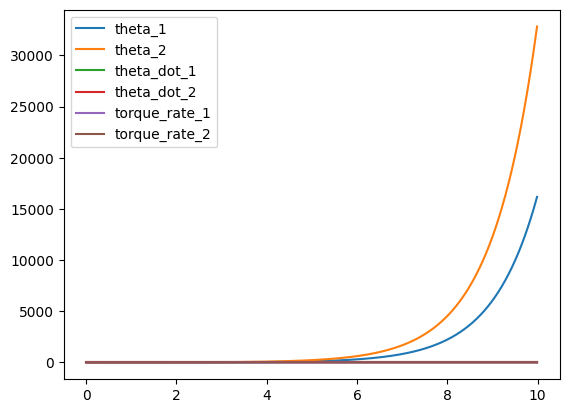

In [41]:
theta_1 = np.pi/4
theta_2 = np.pi/2
theta_dot_1 = 0
theta_dot_2 = 0
T_1 = 0.5
T_2 = 0.5


A_primary = matrix = np.array([
    1, 0, 0, 0, 0, 0,
    0, 1, 0, 0, 0, 0,
    0, 0, -0.2726, 0.2726, 0.0341, -0.0341,
    0, 0, -0.0508, 0.2830, -0.0459, 0.2546,
    0, 0, 0, 0, -16.6667, 0,
    0, 0, 0, 0, 0, -16.6667
]).reshape(6, 6)


B_primary = np.array([0, 0, 0, 0, 1/tau, 1/tau]).reshape(6, 1)

# A = [A*dt + eye(6) , 0 ; 0 , eye(6)]
A = np.concatenate((A_primary * dt + np.eye(6), np.zeros((6, 6))), axis=1)
A = np.concatenate((A, np.concatenate((np.zeros((6, 6)), np.eye(6)), axis=1)), axis=0)
B = np.concatenate((B_primary * dt, np.zeros((6,1))), axis=0)
print("A matrix : ","\n",A)
print("B vector : ","\n",B)
# print("A shape : ", A.shape)
# print("B shape : ", B.shape)
weights = np.array([5,5,1,1,2,2])
Q = cost_matrix(weights, 12)

Qk = np.zeros((12,12))
R = 0.0001
N = 1000
(L, S) = backwards_optimal_control(N, A, B, Q, Qk, R, 12)
x = np.zeros((N,12,1))
x[0,:,:] = np.array([theta_1, theta_2, theta_dot_1, theta_dot_2, T_1, T_2, np.pi/8, np.pi/8, 0, 0, 0.5, 0.5]).reshape((12,1))
x = forward_optimal_control(N, A, B, R, L, x, 12)

x_axis = np.arange(0, 10, dt)
plt.plot(x_axis, x[:,0,0], label = "theta_1")
plt.plot(x_axis, x[:,1,0], label = "theta_2")
plt.plot(x_axis, x[:,2,0], label = "theta_dot_1")
plt.plot(x_axis, x[:,3,0], label = "theta_dot_2")
plt.plot(x_axis, x[:,4,0], label = "torque_rate_1")
plt.plot(x_axis, x[:,5,0], label = "torque_rate_2")
plt.legend()
plt.show()
